In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import pylab
import os
from collections import Counter

import cv2
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Constants and configuration settings can be imported
from src import config

# Auxiliary functions can be imported from src.dataset module
from src.dataset import get_image, get_mask, get_annotations, box_label, plot_boxes, plot_mask, overlay_mask

if "notebooks" in os.getcwd():
    print("Running in Jupyter Notebook")

# Colors for the masks
COLORS = config.COLORS

# The analysis will be performed on Train dataset (check src.config)

annFile='{}/annotations/instances_attributes_{}.json'.format(config.dataDir,config.dataType) # Annotations json
maskFolder='{}/annotations/{}/'.format(config.dataDir, config.dataType)                      # Mask images
imgFolder='{}/images/{}/'.format(config.dataDir,config.dataType)

# initialize COCO api for instance annotations
db=COCO(annFile)                                                                             # Process the annotations in COCO format
d_cats = {x['id']: x['name'] for x in db.dataset['categories']}                              # Get the categories to encode/decode

for k, v in list(d_cats.items())[:5]:
    print(k, ":", v)

loading annotations into memory...
Done (t=7.03s)
creating index...
index created!
loading annotations into memory...
Done (t=7.62s)
creating index...
index created!
0 : shirt, blouse
1 : top, t-shirt, sweatshirt
2 : sweater
3 : cardigan
4 : jacket


Image file: cc0cb541d0c3be2c4d218b3bdd43d12e.jpg


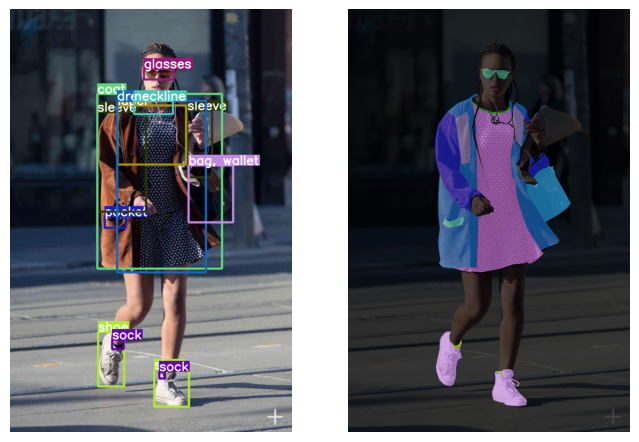

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ids = db.getImgIds()
rnd_id = np.random.choice(ids, 1)
plot_boxes(img_id=rnd_id, ax=ax[0])

image_file = db.loadImgs(rnd_id)[0]['file_name']
print("Image file:", image_file)
overlay_mask(image_file, ax=ax[1])

# VOC PASCAL

In [3]:
pascal_dir = 'datasets/VOCdevkit/VOC2012'

images_dir = os.path.join(pascal_dir, 'JPEGImages')
segmentation_dir = os.path.join(pascal_dir, 'SegmentationClass')

def get_random_image_pascal():
    # Get a random image from the dataset and return the image and the mask
    mask_files = os.listdir(segmentation_dir)
    rnd_file = np.random.choice(mask_files, 1)[0]
    mask_file = os.path.join(segmentation_dir, rnd_file)
    image_file = os.path.join(images_dir, rnd_file[:-4] + '.jpg')
    
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print("Image file:", image_file)
    # print("Mask file:", mask_file)
    mask = cv2.imread(mask_file)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask = make_boolean_mask(mask)

    
    return image, mask

def make_boolean_mask(mask):
    avoid_colors = np.array([[0, 0, 0], [224, 224, 192]])
    
    # Get unique colors in the mask
    colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    
    # Create a boolean mask to identify rows not in avoid_colors
    mask_colors = ~np.isin(colors, avoid_colors).all(axis=1)
    filtered_colors = colors[mask_colors]

    # Get one random colors from filtered colors
    if filtered_colors.shape[0] == 0:
        color = colors[np.random.choice(colors.shape[0], 1)[0]]
    else:
        color = filtered_colors[np.random.choice(filtered_colors.shape[0], 1)[0]]
    
    mask = np.all(mask == color, axis=2)    
    
    return mask  
    

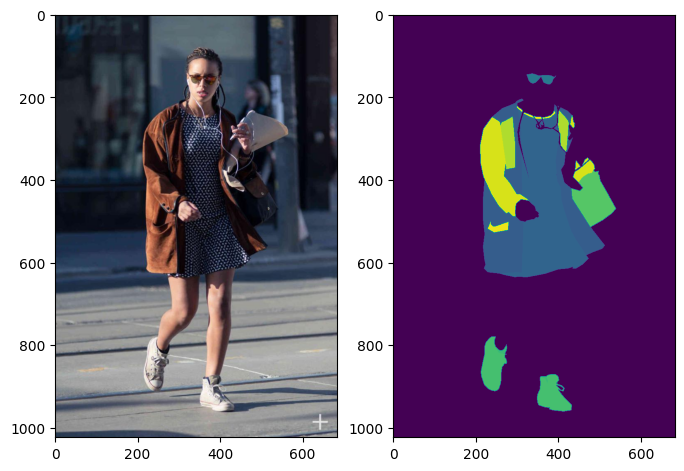

In [4]:
image = get_image(rnd_id)
mask = get_mask(rnd_id)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image)
ax[1].imshow(mask)



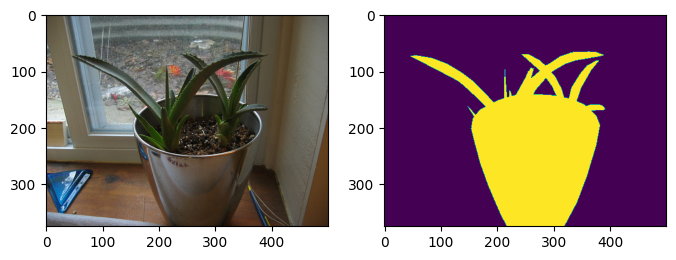

In [5]:
image_pascal, mask_pascal = get_random_image_pascal()

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_pascal)
ax[1].imshow(mask_pascal)

In [6]:

def rotate_image_without_cropping(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    # Calculate the size of the new image
    abs_cos, abs_sin = abs(np.cos(np.radians(angle))), abs(np.sin(np.radians(angle)))
    bound_w = int(h * abs_sin + w * abs_cos)
    bound_h = int(h * abs_cos + w * abs_sin)
    # Adjust the rotation matrix to the center and apply the padding
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotation_matrix[0, 2] += bound_w / 2 - center[0]
    rotation_matrix[1, 2] += bound_h / 2 - center[1]
    rotated_img = cv2.warpAffine(img, rotation_matrix, (bound_w, bound_h))
    return rotated_img

In [7]:
def superpose_pascal_crop(image, mask, image_pascal, mask_pascal):
    
    width, height = image.shape[:2]
    width_pascal, height_pascal = image_pascal.shape[:2]
    
    
    cropped_image_pascal = image_pascal.copy()
    mask_pascal = mask_pascal.astype(bool)
    cropped_image_pascal[~mask_pascal] = 0
    
    # Crop the cropped image so that it has no black borders (rows and columns)
    min_x = np.min(np.where(mask_pascal)[1])
    max_x = np.max(np.where(mask_pascal)[1])
    min_y = np.min(np.where(mask_pascal)[0])
    max_y = np.max(np.where(mask_pascal)[0])
    cropped_image_pascal = cropped_image_pascal[min_y:max_y, min_x:max_x]
    mask_pascal = mask_pascal[min_y:max_y, min_x:max_x]
    width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    
    
    
    
    ### ROTATION ###
    # Add some random rotation to the Pascal image
    angle = np.random.randint(-45, 45)
    cropped_image_pascal = rotate_image_without_cropping(cropped_image_pascal, angle)
    mask_pascal = rotate_image_without_cropping(mask_pascal.astype(np.uint8), angle)
    mask_pascal = mask_pascal.astype(bool)
    
    width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    ##############################################

    
    ### RESIZE ###
    # Resize randomly the Pascal image
    min_scale = 0.8
    max_scale = min(width / width_pascal, height / height_pascal)
    
    scale = np.random.uniform(min_scale, max_scale)
    width_pascal = int(width_pascal * scale)
    height_pascal = int(height_pascal * scale)
    
    
    cropped_image_pascal = cv2.resize(cropped_image_pascal, (height_pascal, width_pascal))
    mask_pascal = cv2.resize(mask_pascal.astype(np.uint8), (height_pascal, width_pascal))
    mask_pascal = mask_pascal.astype(bool)
    width_pascal, height_pascal = cropped_image_pascal.shape[:2]
    
    ##############################################
    
    ### OFFSET ###
    # Calculate center position for superposition
    x = (width - width_pascal) // 2
    y = (height - height_pascal) // 2
    
    # Add some random offset to the center position
    offset_x = np.random.randint(-x//3, x//3) if x > 0 else 0
    offset_y = np.random.randint(-y//2, y//2) if y > 0 else 0
    
    x, y = x + offset_x, y + offset_y
    ##############################################
    
    # print("Offset x:", offset_x, "Offset y:", offset_y, "Rotation angle:", angle, "Scale:", scale)
    
    # Superpose Pascal image on the original image at the calculated center position
    overlaid_image = image.copy()
    
     # Create a mask for the Pascal image where mask_pascal is True
    pascal_mask = np.zeros_like(mask, dtype=bool)
    pascal_mask[x:x+width_pascal, y:y+height_pascal] = mask_pascal
    
    # Overlay Pascal image on the original image at the calculated center position
    overlaid_image = image.copy()
    overlaid_image[pascal_mask] = cropped_image_pascal[mask_pascal]
    
    overlaid_mask = mask.copy() 
    overlaid_mask[pascal_mask] = 0   
    
    
    return overlaid_image, overlaid_mask


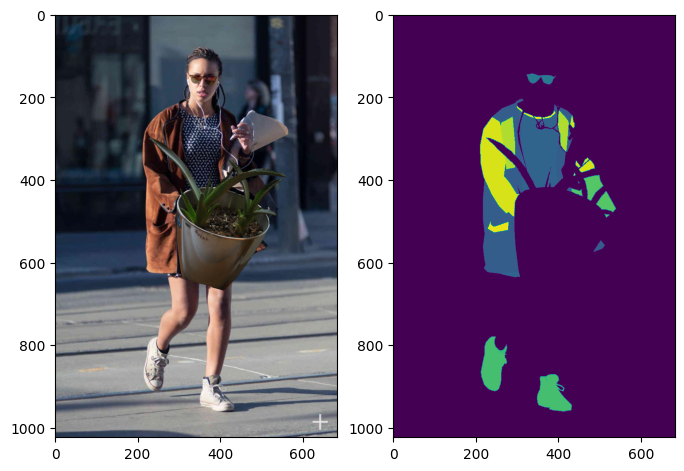

In [8]:
final_image, final_mask = superpose_pascal_crop(image, mask, image_pascal, mask_pascal)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(final_image)
ax[1].imshow(final_mask)


Fashion list: [3920, 11831, 9584, 35941, 26448, 31955, 47391, 49944, 50462, 46294, 41682, 2974, 3456, 5959, 27444, 27406, 35930, 21726, 33841, 14067, 5218, 5121, 45793, 37594, 16957, 17352, 37209, 41226, 40540, 48535]


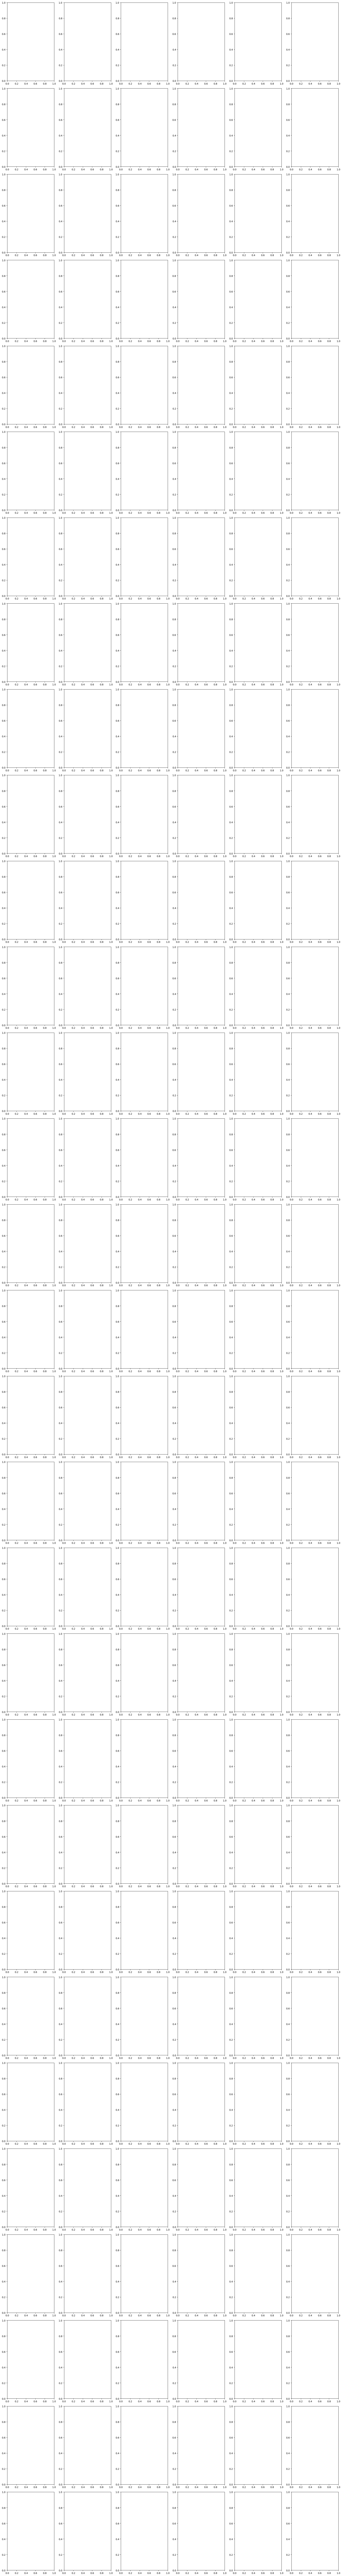

In [14]:
number_of_images = 10
fashion_list = list(np.random.choice(ids, number_of_images))
print("Fashion list:", fashion_list)
fashion_list = [(get_image(np.array([x])), get_mask(np.array([x]))) for x in fashion_list]

pascal_list = [get_random_image_pascal() for _ in range(number_of_images)]

# Plot the images
fig, ax = plt.subplots(number_of_images, 6, figsize=(20, 5 * number_of_images))
for i in range(number_of_images):
    ax[i, 0].imshow(fashion_list[i][0])
    ax[i, 1].imshow(fashion_list[i][1])
    
    ax[i, 2].imshow(pascal_list[i][0])
    ax[i, 3].imshow(pascal_list[i][1])
    
    final_image, final_mask = superpose_pascal_crop(fashion_list[i][0], fashion_list[i][1], pascal_list[i][0], pascal_list[i][1])
    ax[i, 4].imshow(final_image)
    ax[i, 5].imshow(final_mask)
    
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 4].axis('off')
    ax[i, 5].axis('off')
    
plt.tight_layout()
    

The following code is to make sure that the pipeline in src.data_augmentation is working properly

Fashion list: [32923, 875, 15321, 18062, 17444, 1381, 5800, 11088, 30884, 314]


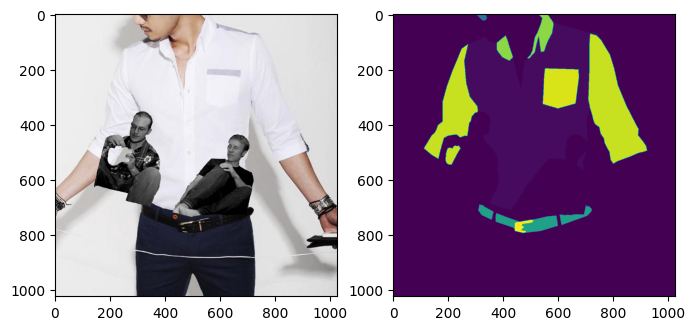

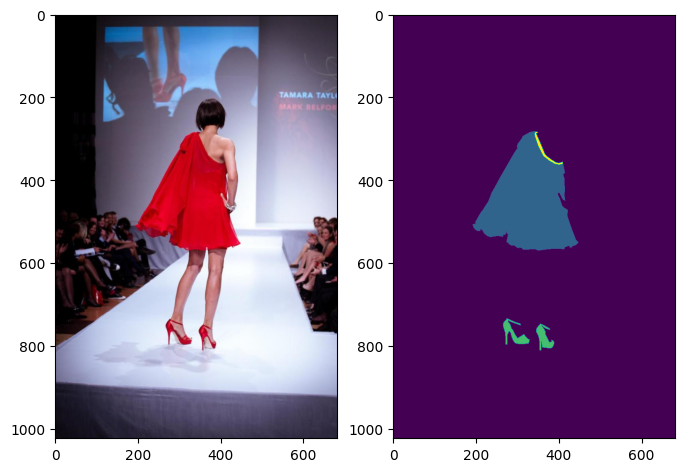

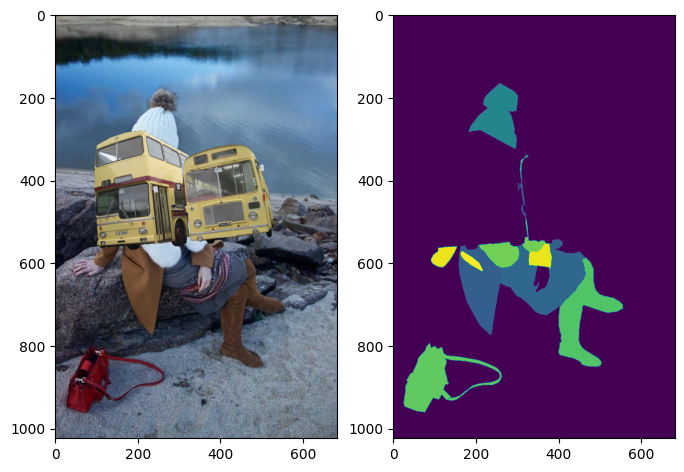

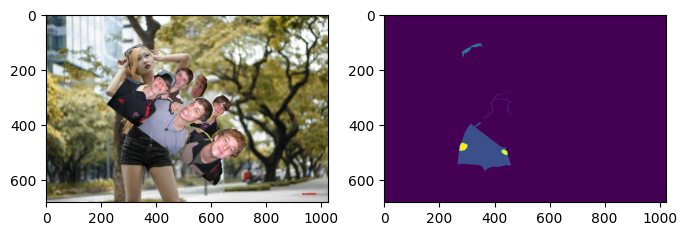

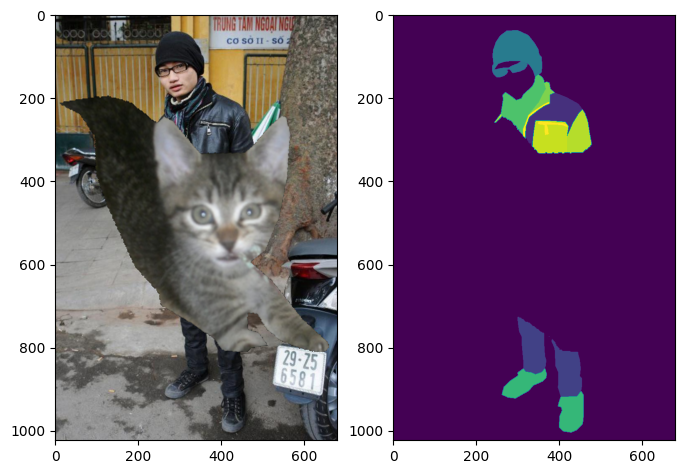

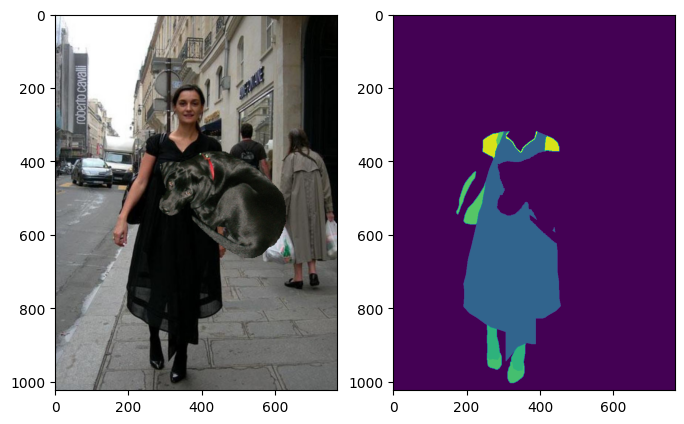

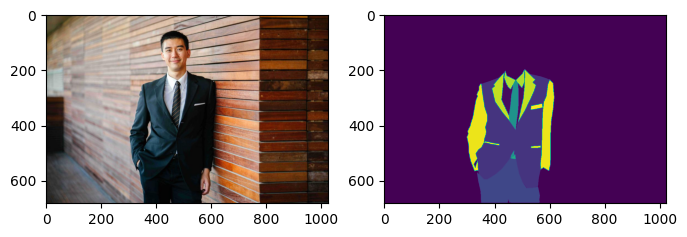

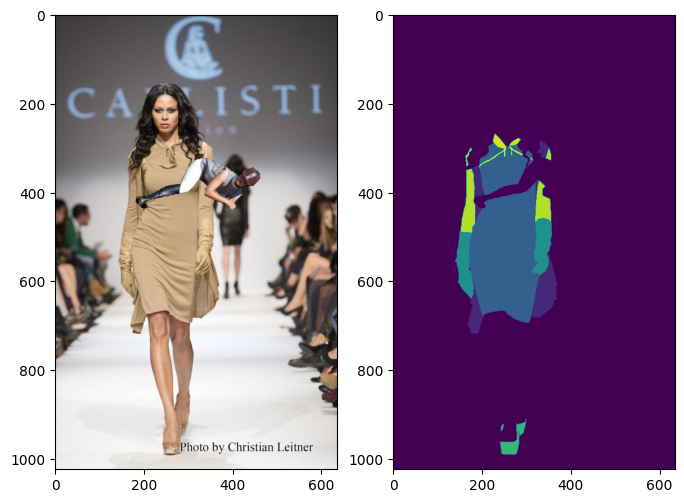

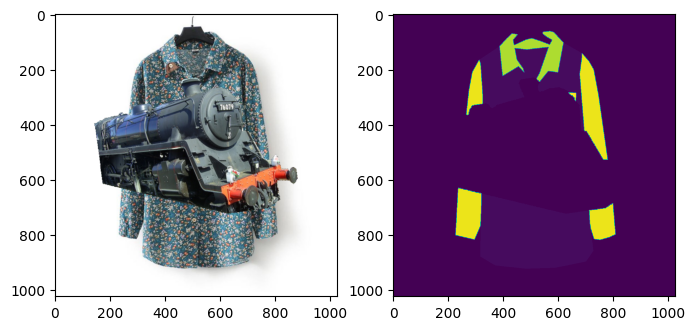

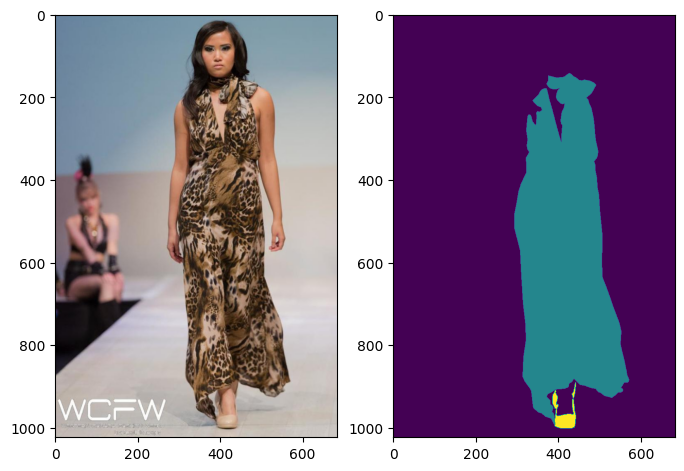

In [11]:
from src.data_augmentation import AddPascalCrop


number_of_images = 10
fashion_list = list(np.random.choice(ids, number_of_images))
print("Fashion list:", fashion_list)
fashion_list = [(get_image(np.array([x])), get_mask(np.array([x]))) for x in fashion_list]

add_pascal_crop = AddPascalCrop(pascal_dataset_path=pascal_dir, prob=1.0)

for i in range(number_of_images):
    input_dict = dict(img=fashion_list[i][0], mask=fashion_list[i][1])
    
    result_dict = add_pascal_crop.transform(input_dict)
    final_image = result_dict['img']
    final_mask = result_dict['mask']
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(final_image)
    ax[1].imshow(final_mask)
    plt.show()